Выполнил: *Мищенко Елена Александровна, группа М24-525*

НИЯУ МИФИ

Вставьте ниже скриншот с результатом вашего решения в Leaderboard на Kaggle: https://www.kaggle.com/competitions/butterflies-classification

*Пример ниже:*

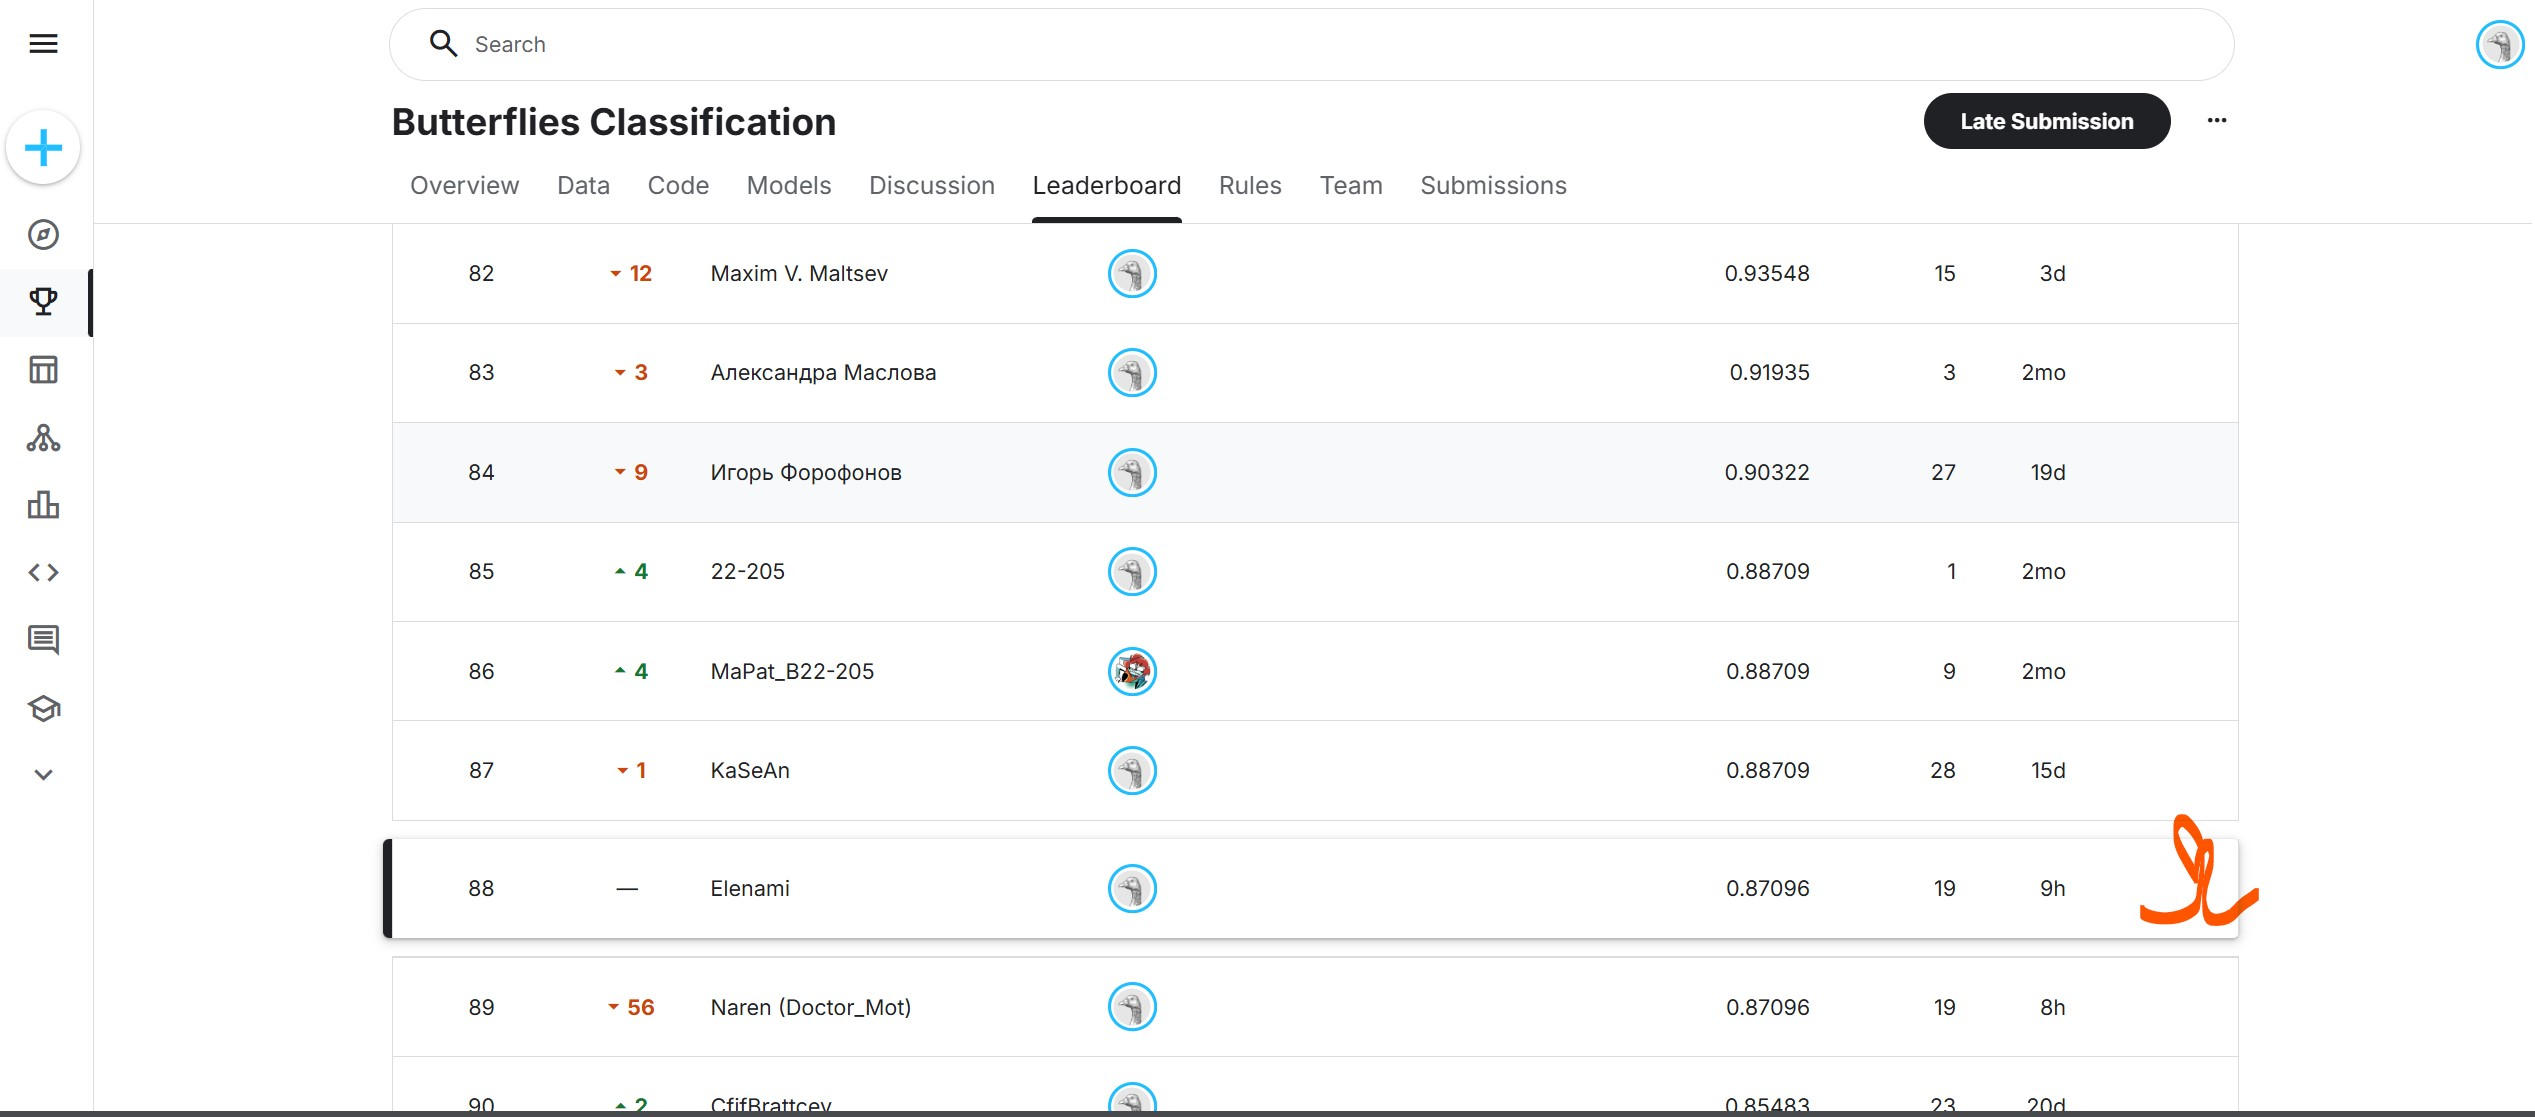

Данный результат был достигнут на обучении модели efficientnet до закрытия соревнования. После закрытия соревнования на каггле результаты были улучшены:

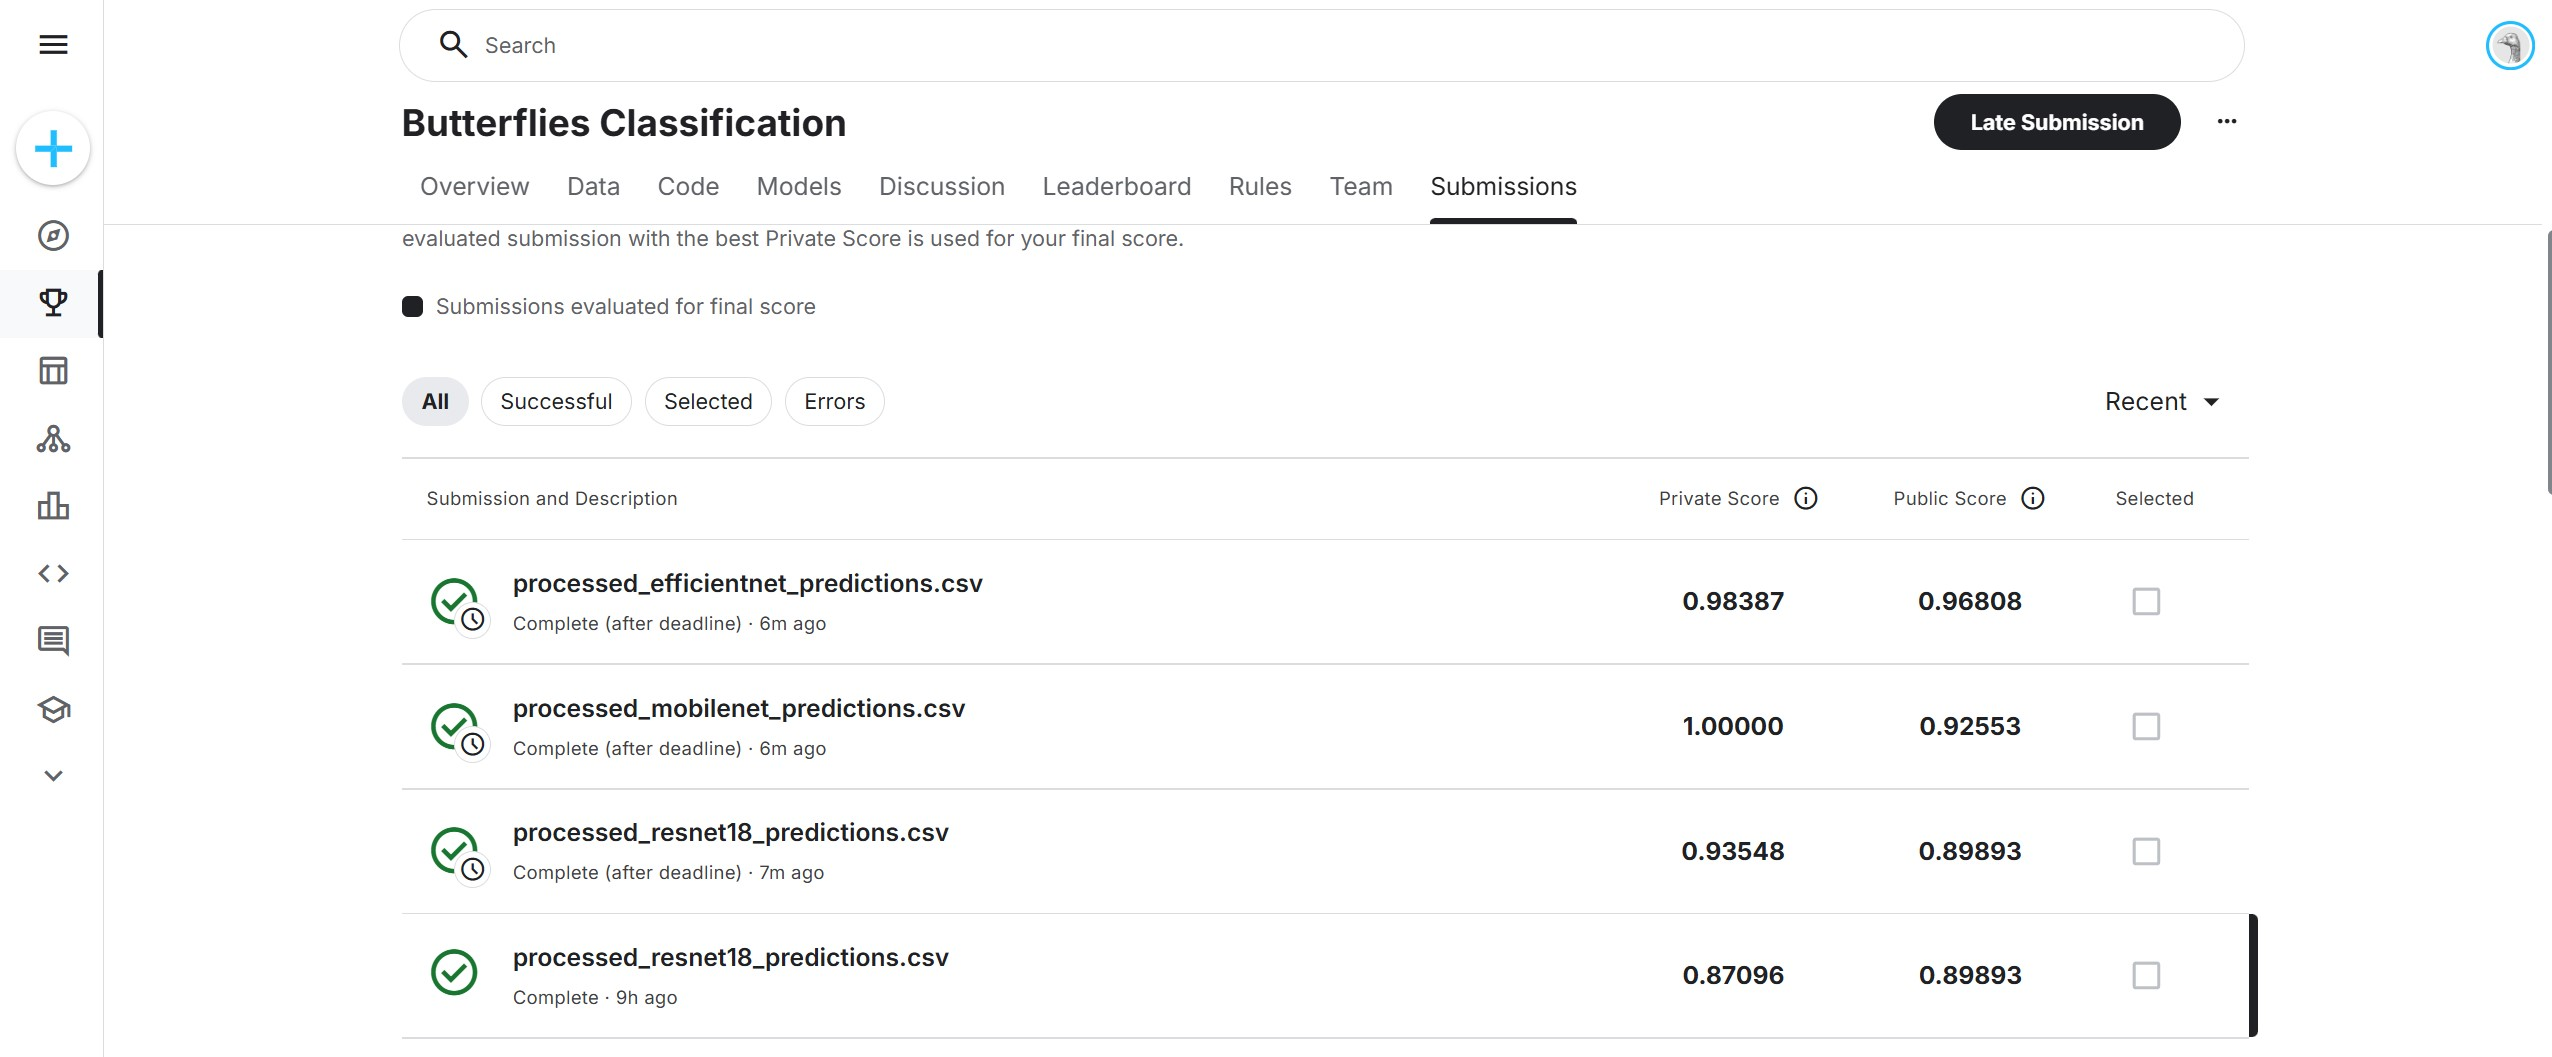

## 1. Описание задачи и данные

Вам необходимо решить задачу классификации фотографий бабочек на 50 классов. Каждая фотография представляет из себя цветное изображение размера 224×224.

Вам предоставлены два набора данных:

- Папка train содержит в себе 50 папок, разбитых на классы.
- Папка test содержит в себе 250 фотографий, которые вам необходимо классифицировать.
- Решение оценивается метрикой accuracy.

Ссылка на соревнование и на данные: https://www.kaggle.com/competitions/butterflies-classification

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch import nn, optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from collections import defaultdict
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

## 1. Провести предварительное исследование данных

- сколько у вас есть изображений? Все ли они одного разрешения? Какой баланс классов в данных?
- какие есть особенности датасета?
- если необходимо произвести очистку и предварительную обработку данных.

Всего изображений train: 4955
Разрешения в train: {(224, 224)}

Всего изображений test: 250
Разрешения в test: {(224, 224)}


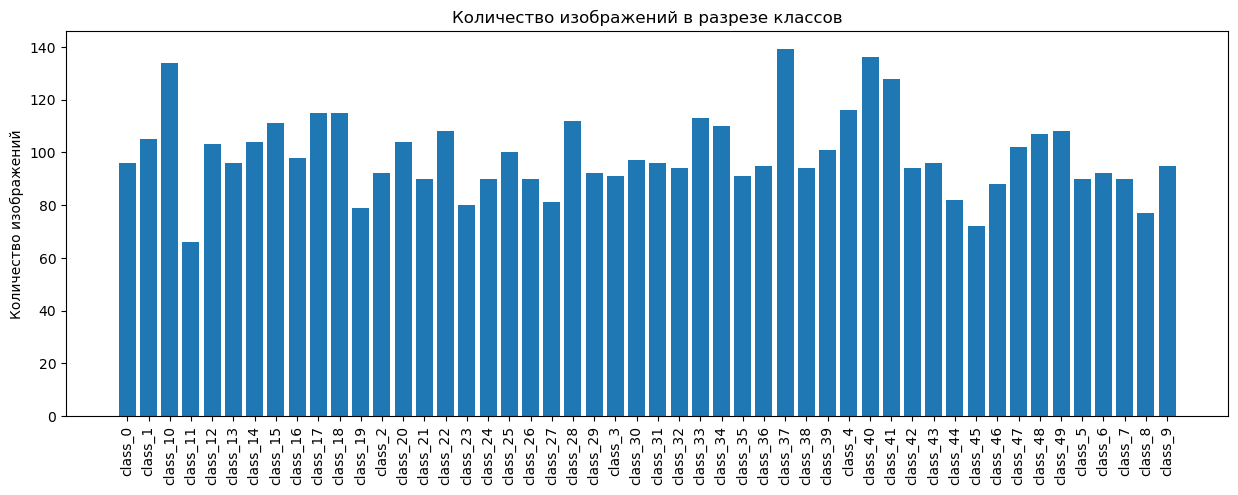


Класс с минимальным количеством изображений: class_11 (66 изображений)
Класс с максимальным количеством изображений: class_37 (139 изображений)
Среднее количество изображений на класс: 99.1


dict_keys(['class_0', 'class_1', 'class_10', 'class_11', 'class_12', 'class_13', 'class_14', 'class_15', 'class_16', 'class_17', 'class_18', 'class_19', 'class_2', 'class_20', 'class_21', 'class_22', 'class_23', 'class_24', 'class_25', 'class_26', 'class_27', 'class_28', 'class_29', 'class_3', 'class_30', 'class_31', 'class_32', 'class_33', 'class_34', 'class_35', 'class_36', 'class_37', 'class_38', 'class_39', 'class_4', 'class_40', 'class_41', 'class_42', 'class_43', 'class_44', 'class_45', 'class_46', 'class_47', 'class_48', 'class_49', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9'])

In [ ]:
train_path = 'butterflies-classification/train_butterflies/train_split'
test_path = 'butterflies-classification/test_butterflies/valid'

def analyze_dataset(dataset_path):
    class_counts = {}
    resolutions = set()
    total_images = 0

    for class_name in os.listdir(dataset_path):
        class_dir = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_dir):
            images = os.listdir(class_dir)
            class_counts[class_name] = len(images)
            total_images += len(images)

            for img_name in images[:5]:
                img_path = os.path.join(class_dir, img_name)
                with Image.open(img_path) as img:
                    resolutions.add(img.size)

    return class_counts, total_images, resolutions

class_counts, total_train, train_resolutions = analyze_dataset(train_path)
print(f"Всего изображений train: {total_train}")
print(f"Разрешения в train: {train_resolutions}")

test_images = os.listdir(test_path)
print(f"\nВсего изображений test: {len(test_images)}")

test_resolutions = set()
for img_name in test_images[:20]:
    img_path = os.path.join(test_path, img_name)
    with Image.open(img_path) as img:
        test_resolutions.add(img.size)
print(f"Разрешения в test: {test_resolutions}")


plt.figure(figsize=(15, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=90)
plt.title("Количество изображений в разрезе классов")
plt.ylabel("Количество изображений")
plt.show()

min_class = min(class_counts, key=class_counts.get)
max_class = max(class_counts, key=class_counts.get)
print(f"\nКласс с минимальным количеством изображений: {min_class} ({class_counts[min_class]} изображений)")
print(f"Класс с максимальным количеством изображений: {max_class} ({class_counts[max_class]} изображений)")
print(f"Среднее количество изображений на класс: {total_train / len(class_counts):.1f}")
class_counts.keys()

**Выводы:**
Все изображения одного размера, что позволяет дальше работать с данными. Также исходя из графика можно обратить внимание на то, что присутствует небольшой, но не критический дисбаланс классов.
Сортировка классов также не совсем очевидна, после class_1 идет сразу же class_10, class_11 и т.д.

## 2. Подготовить данные для обучения

- Создать тренировочную и тестовую подвыборки для обучения и тестирования работы моделей
- Создать класс на фреймворке `PyTorch` для создания датасета
- Создать `loader` для передачи данных в модель нейронной сети

In [ ]:
# подготовка данных, распределение на обучающую и валидационную выборки
class ButterflyDataset(Dataset):
    def __init__(self, data_path, transform=None, split='train', test_size=0.2):
        self.data_path = data_path
        self.transform = transform
        self.classes = sorted(os.listdir(data_path))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.images = []
        self.labels = []

        for class_name in self.classes:
            class_dir = os.path.join(data_path, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    self.images.append(os.path.join(class_dir, img_name))
                    self.labels.append(self.class_to_idx[class_name])

        if split in ['train', 'val']:
            train_idx, val_idx = train_test_split(
                range(len(self.images)),
                test_size=test_size,
                stratify=self.labels,
                random_state=42
            )
            if split == 'train':
                self.images = [self.images[i] for i in train_idx]
                self.labels = [self.labels[i] for i in train_idx]
            else:
                self.images = [self.images[i] for i in val_idx]
                self.labels = [self.labels[i] for i in val_idx]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

class TestDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.images = sorted([os.path.join(data_path, img) for img in os.listdir(data_path)])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, os.path.basename(img_path)

In [ ]:
# трансформации, в том числе нормализация
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# подготовка датасетов и загрузчиков
batch_size = 32
train_dataset = ButterflyDataset(train_path, transform=train_transforms, split='train')
val_dataset = ButterflyDataset(train_path, transform=val_transforms, split='val')
test_dataset = TestDataset(test_path, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

## 3. Реализация модели

- создать класс для модели
- создать функцию для обучения модели
- создать функцию для валидации модели

In [ ]:
class ButterflyClassifier(nn.Module):
    def __init__(self, num_classes=50, model_name='resnet18', pretrained=True):
        super().__init__()
        self.model_name = model_name

        if model_name == 'resnet18':
            self.model = models.resnet18(pretrained=pretrained)
            num_features = self.model.fc.in_features
            self.model.fc = nn.Linear(num_features, num_classes)
        elif model_name == 'efficientnet':
            self.model = models.efficientnet_b0(pretrained=pretrained)
            num_features = self.model.classifier[1].in_features
            self.model.classifier[1] = nn.Linear(num_features, num_classes)
        elif model_name == 'mobilenet':
            self.model = models.mobilenet_v2(pretrained=pretrained)
            num_features = self.model.classifier[1].in_features
            self.model.classifier[1] = nn.Linear(num_features, num_classes)
        else:
            raise ValueError(f"Unknown model name: {model_name}")

    def forward(self, x):
        return self.model(x)

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = model.to(device)
    best_acc = 0.0

    history = {
        'loss': [],
        'accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)

        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            pbar.set_postfix({
                'loss': running_loss / total,
                'acc': 100 * correct / total
            })

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = 100 * correct / total

        val_loss, val_acc = validate_model(model, val_loader, criterion, device)

        history['loss'].append(train_loss)
        history['accuracy'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}: '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f'best_{model.model_name}.pth')

    print(f'Обучение завершено. Лучший Val Acc: {best_acc:.2f}%')
    return model, history

def plot_model_metrics(history, model_name):
    epochs = range(1, len(history['loss']) + 1)

    fig, ax1 = plt.subplots(figsize=(8, 6))

    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(epochs, history['loss'], label='Train Loss', color=color)
    ax1.plot(epochs, history['val_loss'], label='Val Loss', linestyle='--', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(epochs, history['accuracy'], label='Train Accuracy', color=color)
    ax2.plot(epochs, history['val_accuracy'], label='Val Accuracy', linestyle='--', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title(f'Метрики для {model_name}')

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    plt.legend(lines + lines2, labels + labels2, loc='upper right')

    plt.show()

In [ ]:
def validate_model(model, val_loader, criterion, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(val_loader.dataset)
    val_acc = 100 * correct / total

    return val_loss, val_acc

## 4. Обучение модели
*   Определить необходимые параметры для обучения модели (learning rate, optimizer, loss function, etc)
*   Реализовать процесс обучения модели
*   Оценить эффективность работы модели




Обучение resnet18 модели...


Epoch 1/6: Train Loss: 1.2715, Train Acc: 64.58% | Val Loss: 0.9045, Val Acc: 73.56%


Epoch 2/6: Train Loss: 0.5446, Train Acc: 84.16% | Val Loss: 0.7089, Val Acc: 80.02%


Epoch 3/6: Train Loss: 0.4423, Train Acc: 86.73% | Val Loss: 0.7879, Val Acc: 80.22%


Epoch 4/6: Train Loss: 0.3233, Train Acc: 89.91% | Val Loss: 1.0027, Val Acc: 72.55%


Epoch 5/6: Train Loss: 0.2671, Train Acc: 92.23% | Val Loss: 0.4215, Val Acc: 90.92%


Epoch 6/6: Train Loss: 0.2340, Train Acc: 92.63% | Val Loss: 0.5565, Val Acc: 84.46%
Обучение завершено. Лучший Val Acc: 90.92%


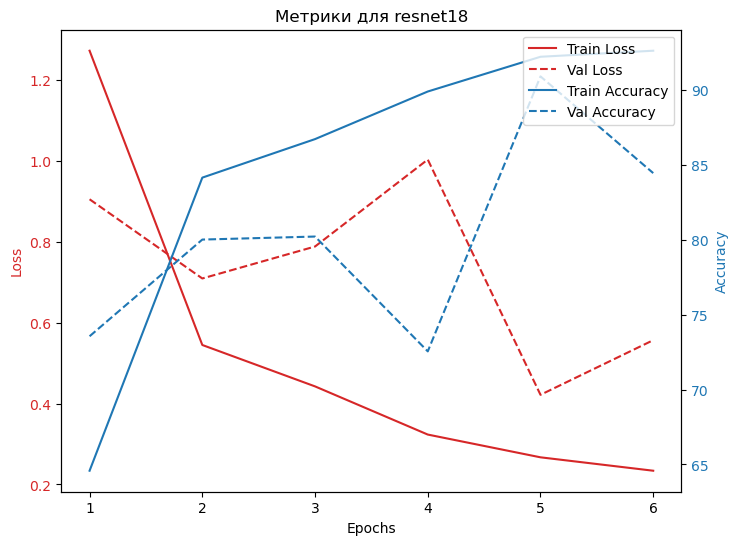


Обучение efficientnet модели...


Epoch 1/6: Train Loss: 1.0504, Train Acc: 75.03% | Val Loss: 0.4282, Val Acc: 87.99%


Epoch 2/6: Train Loss: 0.3593, Train Acc: 89.78% | Val Loss: 0.4235, Val Acc: 88.50%


Epoch 3/6: Train Loss: 0.2380, Train Acc: 92.43% | Val Loss: 0.3039, Val Acc: 92.43%


Epoch 4/6: Train Loss: 0.1551, Train Acc: 95.33% | Val Loss: 0.3645, Val Acc: 92.13%


Epoch 5/6: Train Loss: 0.1463, Train Acc: 95.26% | Val Loss: 0.3136, Val Acc: 92.63%


Epoch 6/6: Train Loss: 0.1361, Train Acc: 96.42% | Val Loss: 0.3637, Val Acc: 92.03%
Обучение завершено. Лучший Val Acc: 92.63%


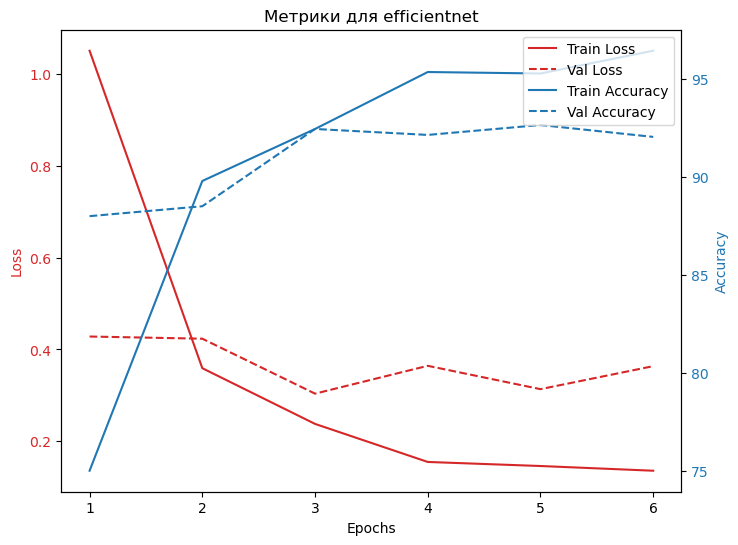


Обучение mobilenet модели...


Epoch 1/6: Train Loss: 1.1428, Train Acc: 70.06% | Val Loss: 0.5683, Val Acc: 82.34%


Epoch 2/6: Train Loss: 0.5091, Train Acc: 83.88% | Val Loss: 0.4346, Val Acc: 86.98%


Epoch 3/6: Train Loss: 0.3559, Train Acc: 89.05% | Val Loss: 0.4523, Val Acc: 86.68%


Epoch 4/6: Train Loss: 0.3193, Train Acc: 90.49% | Val Loss: 0.4180, Val Acc: 87.89%


Epoch 5/6: Train Loss: 0.2702, Train Acc: 92.23% | Val Loss: 0.3794, Val Acc: 89.30%


Epoch 6/6: Train Loss: 0.2614, Train Acc: 92.23% | Val Loss: 0.4292, Val Acc: 90.62%
Обучение завершено. Лучший Val Acc: 90.62%


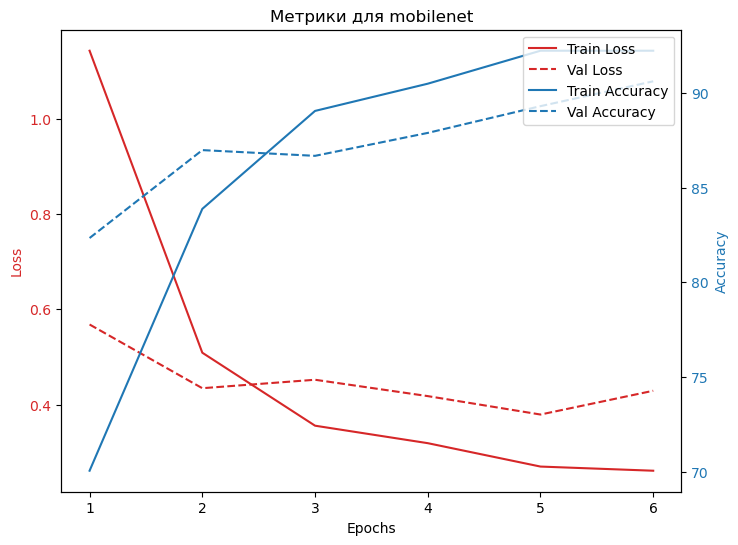


Сравнение моделей:
resnet18: Val Loss: 0.4215, Val Acc: 90.92%
efficientnet: Val Loss: 0.3136, Val Acc: 92.63%
mobilenet: Val Loss: 0.4292, Val Acc: 90.62%


In [ ]:
def train_and_evaluate(model_name, learning_rate=0.001, num_epochs=6):
    print(f"\nОбучение {model_name} модели...")
    model = ButterflyClassifier(num_classes=50, model_name=model_name)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    trained_model, history = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        num_epochs=num_epochs
    )

    plot_model_metrics(history, model_name)

    return trained_model, history

models_to_train = ['resnet18', 'efficientnet', 'mobilenet']
trained_models = {}
histories = {}

for model_name in models_to_train:
    model, history = train_and_evaluate(model_name)
    trained_models[model_name] = model
    histories[model_name] = history

def predict_test_set(model, test_loader, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.eval()
    predictions = {}

    with torch.no_grad():
        for inputs, img_names in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            for img_name, pred in zip(img_names, predicted.cpu().numpy()):
                predictions[img_name] = pred

    return predictions

print("\nСравнение моделей:")
for model_name, model in trained_models.items():
    model.load_state_dict(torch.load(f'best_{model_name}.pth'))
    val_loss, val_acc = validate_model(model, val_loader, nn.CrossEntropyLoss())
    print(f"{model_name}: Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

**Выводы:**
Для обучения были использованы 3 модели - ResNet50 (хороший баланс между точностью и скоростью обучения), EfficientNetB0 (большая точность, но требует больше ресурсов) и MobileNetV2 (быстрее всего работает). Все модели показали достаточно неплохие результаты на 6 эпохах как на тестовых данных, так и на валидационных. Наилучшие показатели у модели efficientnet на валидационных данных (асс=92,63%, loss=0.3136).

## 5. Экспериментальная часть

- протестировать не менее 3х разных моделей для решения задачи
- сравнить их эффективность (по метрикам и потерям)
- сделать выводы

In [ ]:
class_names = sorted(os.listdir(train_path))
for model_name in models_to_train:
    model = ButterflyClassifier(num_classes=50, model_name=model_name)
    model.load_state_dict(torch.load(f'best_{model_name}.pth'))
    model = model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    predictions = predict_test_set(model, test_loader)
    with open(f'{model_name}_predictions.csv', 'w') as f:
        f.write("image_name,class\n")
        for img_name, pred in predictions.items():
            f.write(f"{img_name},{class_names[pred]}\n")

    print(f"{model_name} Предсказание сохранено в файл {model_name}_predictions.csv")

resnet18 Предсказание сохранено в файл resnet18_predictions.csv
efficientnet Предсказание сохранено в файл efficientnet_predictions.csv
mobilenet Предсказание сохранено в файл mobilenet_predictions.csv


Преобразуем полученные итоговые файлы предсказаний (так как есть "изюминка" в порядке наименований классов) и проверим результаты на каггле.

In [ ]:
filename = 'resnet18_predictions.csv'
df = pd.read_csv(filename)
df.columns = ['index', 'label']
df['index'] = df['index'].apply(lambda x: os.path.splitext(str(x))[0] if pd.notnull(x) else x)
df['label'] = df['label'].apply(lambda x: x.replace('class_', '') if isinstance(x, str) else x)
df['index'] = pd.to_numeric(df['index'], errors='coerce')
df['label'] = pd.to_numeric(df['label'], errors='coerce')
df = df.sort_values(by='index', ascending=True)
df.to_csv('processed_' + filename, index=False)
print("Обработка завершена, сохранено в processed_" + filename)

Обработка завершена, сохранено в processed_resnet18_predictions.csv


Результат на каггле:

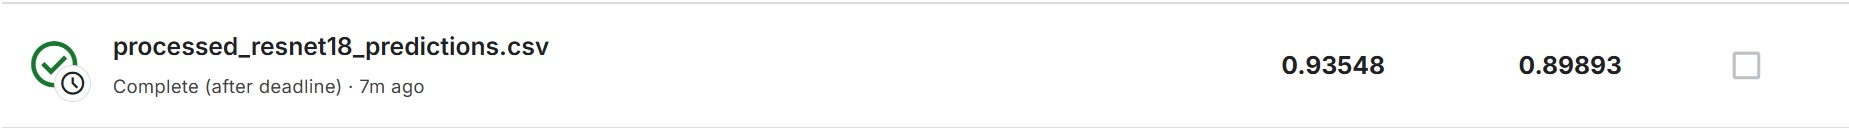

In [ ]:
filename = 'mobilenet_predictions.csv'
df = pd.read_csv(filename)
df.columns = ['index', 'label']
df['index'] = df['index'].apply(lambda x: os.path.splitext(str(x))[0] if pd.notnull(x) else x)
df['label'] = df['label'].apply(lambda x: x.replace('class_', '') if isinstance(x, str) else x)
df['index'] = pd.to_numeric(df['index'], errors='coerce')
df['label'] = pd.to_numeric(df['label'], errors='coerce')
df = df.sort_values(by='index', ascending=True)
df.to_csv('processed_' + filename, index=False)
print("Обработка завершена, сохранено в processed_" + filename)

Обработка завершена, сохранено в processed_mobilenet_predictions.csv


Результат на каггле:

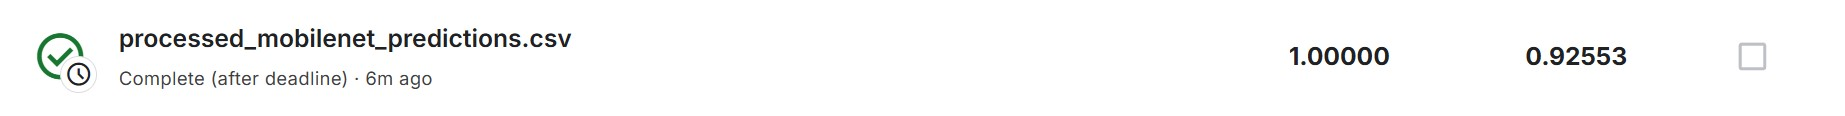

In [ ]:
filename = 'efficientnet_predictions.csv'
df = pd.read_csv(filename)
df.columns = ['index', 'label']
df['index'] = df['index'].apply(lambda x: os.path.splitext(str(x))[0] if pd.notnull(x) else x)
df['label'] = df['label'].apply(lambda x: x.replace('class_', '') if isinstance(x, str) else x)
df['index'] = pd.to_numeric(df['index'], errors='coerce')
df['label'] = pd.to_numeric(df['label'], errors='coerce')
df = df.sort_values(by='index', ascending=True)
df.to_csv('processed_' + filename, index=False)
print("Обработка завершена, сохранено в processed_" + filename)

Обработка завершена, сохранено в processed_efficientnet_predictions.csv


Результат на каггле:

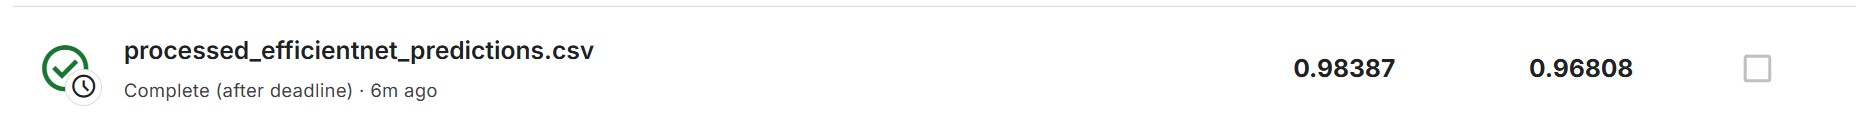

**ИТОГОВЫЙ ВЫВОД:**
Файлы с предсказаниями были сформированы для всех трех моделей и загружены на каггл (после дедлайна сореванования, но на скриншотах виден общий скор). Таким образом, на каггле лучший результат на тесте показали модели mobilenet и efficientnet, как и на тренировочных и валидационных данных. Полагаю, что можно попробовать еще немного улучшить результат, увеличив число эпох обучения, то есть дообучать модель, и в целом провести более тонкую настройку гиперпараметров. Но в целом и сейчас достигнуты хорошие результаты. В целом, для максимальной точности рекомендуется использовать модель efficientnet, для баланса точности и скорости модель resnet18_predictions, для работы с ресурсоограниченными приложениями - модель mobilenet.